# Project: Pump It Up – Predicting Waterpoint Operational Status

## Problem Definition

Access to clean and reliable water is a fundamental human need and a cornerstone of public health and sustainable development. In Tanzania, waterpoints—such as wells and boreholes—are critical infrastructure for both rural and urban communities. However, many waterpoints are poorly maintained or fail due to age, environmental conditions, or inadequate management.

This project focuses on predicting the operational status of waterpoints to enable proactive maintenance and optimize resource allocation. The goal is to classify each waterpoint into one of three categories:

1. **Functional** – Fully operational with no repairs needed.  
2. **Functional needs repair** – Operational but requires maintenance.  
3. **Non-functional** – Not operational and unable to provide water.  

The dataset includes physical characteristics (e.g., `amount_tsh`, `gps_height`), installation and management details (`installer`, `management`, `scheme_management`), water quality and quantity (`water_quality`, `quantity`), and geographic information (`region`, `district_code`, `latitude`, `longitude`). Manual monitoring is slow and resource-intensive, so a machine learning solution can help predict failures before they occur.

## Importance and Impact

Implementing a predictive model for waterpoint status can significantly benefit communities, governments, and NGOs:

- **Proactive Maintenance:** Predict failures to reduce downtime and maintain consistent access to clean water.  
- **Optimized Resource Allocation:** Prioritize waterpoints that require attention, making maintenance efforts more efficient.  
- **Improved Public Health:** Ensure access to safe water, lowering the risk of waterborne diseases.  
- **Data-Driven Decision Making:** Enable strategic planning based on predictive insights rather than reactive reporting.  
- **Enhanced Civic Engagement:** Provide communities with timely and reliable information about waterpoint conditions.  
- **Cost Savings:** Reduce emergency repair costs, extend the lifespan of waterpoints, and make better use of financial and human resources.  

By transforming raw waterpoint data into actionable insights, this project bridges the gap between data collection and practical infrastructure management, making a tangible difference in the lives of Tanzanian communities.


# Step 1: Data Preeparation

In [ ]:
# Import essential libraries
import pandas as pd
import numpy as np

# For encoding categorical variables
from sklearn.preprocessing import LabelEncoder

# For data visualization (optional, will be used later)
import matplotlib.pyplot as plt
import seaborn as sns

'''
Explanation:
	•	pandas & numpy → for data handling and numerical operations.
	•	LabelEncoder → for encoding categorical features.
	•	matplotlib & seaborn → for visualizations (optional for later steps).
'''

# Loading the Data set

In [2]:
# Load training features and labels
train_values = pd.read_csv("training_set_values.csv")
train_labels = pd.read_csv("training_set_labels.csv")

# Load test features
test_values = pd.read_csv("test_set_values.csv")

# Load submission format
submission_format = pd.read_csv("Submissionformat.csv")

# Quick look at shapes
print("Training features shape:", train_values.shape)
print("Training labels shape:", train_labels.shape)
print("Test features shape:", test_values.shape)
print("Submission format shape:", submission_format.shape)

# Preview first few rows of training features
train_values.head()

'''
Explanation:
	•	Loads all CSVs from your directory into pandas DataFrames.
	•	Prints the shapes so you immediately see how many rows and columns you have.
	•	Shows the first few rows of train_values to get a sense of the data.
'''

Training features shape: (59400, 40)
Training labels shape: (59400, 2)
Test features shape: (14850, 40)
Submission format shape: (14850, 2)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


# Inspecting the data

In [3]:
# Identify categorical columns in the training data
categorical_cols = train_values.select_dtypes(include=['object']).columns
print("Categorical columns in the training set:")
for col in categorical_cols:
    print("-", col)

# Optional: see a sample of unique values for one or two categorical columns
print("\nSample unique values for 'funder':", train_values['funder'].unique()[:10])
print("Sample unique values for 'installer':", train_values['installer'].unique()[:10])

'''
Explanation:
	•	select_dtypes(include=['object']) picks up all text/categorical columns.
	•	We print the column names so you can see what needs encoding.
	•	The optional lines let you peek at the first few unique values of some categorical columns to understand the data better.
'''

Categorical columns in the training set:
- date_recorded
- funder
- installer
- wpt_name
- basin
- subvillage
- region
- lga
- ward
- public_meeting
- recorded_by
- scheme_management
- scheme_name
- permit
- extraction_type
- extraction_type_group
- extraction_type_class
- management
- management_group
- payment
- payment_type
- water_quality
- quality_group
- quantity
- quantity_group
- source
- source_type
- source_class
- waterpoint_type
- waterpoint_type_group

Sample unique values for 'funder': ['Roman' 'Grumeti' 'Lottery Club' 'Unicef' 'Action In A'
 'Mkinga Distric Coun' 'Dwsp' 'Rwssp' 'Wateraid' 'Isingiro Ho']
Sample unique values for 'installer': ['Roman' 'GRUMETI' 'World vision' 'UNICEF' 'Artisan' 'DWE' 'DWSP'
 'Water Aid' 'Private' 'DANIDA']


# Encoding Variables

In [9]:
# Make fresh copies of original data
train_encoded = train_values.copy()
test_encoded = test_values.copy()

# --- Step 1: Handle 'date_recorded' ---
train_encoded['date_recorded'] = pd.to_datetime(train_encoded['date_recorded'])
test_encoded['date_recorded'] = pd.to_datetime(test_encoded['date_recorded'])

# Extract year, month, day
for df in [train_encoded, test_encoded]:
    df['recorded_year'] = df['date_recorded'].dt.year
    df['recorded_month'] = df['date_recorded'].dt.month
    df['recorded_day'] = df['date_recorded'].dt.day

# Drop original date column
train_encoded.drop('date_recorded', axis=1, inplace=True)
test_encoded.drop('date_recorded', axis=1, inplace=True)

# --- Step 2: Drop high-cardinality columns ---
high_card_cols = ['wpt_name', 'scheme_name', 'subvillage']
train_encoded.drop(columns=high_card_cols, inplace=True)
test_encoded.drop(columns=high_card_cols, inplace=True)

# --- Step 3: Encode remaining categorical columns ---
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_cols = train_encoded.select_dtypes(include=['object']).columns
encoders = {}  # store encoders

for col in categorical_cols:
    le = LabelEncoder()
    train_encoded[col] = le.fit_transform(train_encoded[col].astype(str))
    
    # Map test values, unseen values get -1
    test_encoded[col] = test_encoded[col].astype(str)
    known_classes = set(le.classes_)
    test_encoded[col] = test_encoded[col].apply(lambda x: le.transform([x])[0] if x in known_classes else -1)
    
    encoders[col] = le

# Quick check
print("Categorical columns encoded:", list(categorical_cols))
train_encoded.head()

'''
Perfect! Let’s rewrite your encoding variables cell so it’s fast and safe. We’ll:
	1.	Handle date_recorded → extract year/month/day.
	2.	Drop high-cardinality columns that slow down encoding.
	3.	Label encode the remaining categorical columns.
	4.	Make it safe for unseen values in the test set.
'''

Categorical columns encoded: ['funder', 'installer', 'basin', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


,id,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,region,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,recorded_year,recorded_month,recorded_day
0,69572,6000.0,1368,1390,1518,34.938093,-9.856322,0,1,3,...,1,1,8,6,0,1,1,2011,3,14
1,8776,0.0,469,1399,545,34.698766,-2.147466,0,4,9,...,2,2,5,3,1,1,1,2013,3,6
2,34310,25.0,825,686,2048,37.460664,-3.821329,0,5,8,...,1,1,0,1,1,2,1,2013,2,25
3,67743,0.0,1740,263,1852,38.486161,-11.155298,0,7,12,...,0,0,3,0,0,2,1,2013,1,28
4,19728,0.0,20,0,119,31.130847,-1.825359,0,4,4,...,3,3,5,3,1,1,1,2011,7,13


# Handling missing values

In [ ]:
# --- Step 4: Handle missing values ---

# Check missing values in training set
missing_train = train_encoded.isnull().sum()
print("Missing values in training set:\n", missing_train[missing_train > 0])

# Check missing values in test set
missing_test = test_encoded.isnull().sum()
print("\nMissing values in test set:\n", missing_test[missing_test > 0])

# --- Strategy ---
# For numeric columns: fill missing values with median
numeric_cols = train_encoded.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    median_val = train_encoded[col].median()
    train_encoded[col].fillna(median_val, inplace=True)
    test_encoded[col].fillna(median_val, inplace=True)

# For categorical columns: fill missing values with mode
categorical_cols = train_encoded.select_dtypes(include=['int64']).columns.difference(numeric_cols)

for col in categorical_cols:
    mode_val = train_encoded[col].mode()[0]
    train_encoded[col].fillna(mode_val, inplace=True)
    test_encoded[col].fillna(mode_val, inplace=True)

# Quick check to confirm no missing values remain
print("\nMissing values after imputation (train):", train_encoded.isnull().sum().sum())
print("Missing values after imputation (test):", test_encoded.isnull().sum().sum())

'''
✅ Explanation
	1.	Check missing values to see which columns have NaN.
	2.	Numeric columns → fill with median (robust to outliers).
	3.	Categorical columns → fill with mode (most frequent value).
	4.	Ensures train and test sets are consistent.
	5.	Final check confirms no missing values remain.
'''




# Identify Features X and Target Y

In [11]:
# --- Step 5: Identify features X and target y ---

# Drop the target column from features
X = train_encoded.copy()
y = train_labels['status_group']  # this is the target

# For test set
X_test = test_encoded.copy()

# Quick check
print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Test features shape:", X_test.shape)

'''
Explanation
1. The target variable is 'status_group' from the labels dataset.
2. X contains all the feature columns from the training set (after encoding and missing value handling).
3. y contains only the target variable for supervised learning.
4. X_test contains the same feature columns as X for the test dataset.
5. This separation prepares the data for modeling in machine learning algorithms.
'''

Features shape: (59400, 39)
Target shape: (59400,)
Test features shape: (14850, 39)


"\nExplanation\n1. The target variable is 'status_group' from the labels dataset.\n2. X contains all the feature columns from the training set (after encoding and missing value handling).\n3. y contains only the target variable for supervised learning.\n4. X_test contains the same feature columns as X for the test dataset.\n5. This separation prepares the data for modeling in machine learning algorithms.\n"

# Feature Engineering

In [14]:
# --- Step 6: Feature Engineering ---

for df in [X, X_test]:
    # Waterpoint age
    df['waterpoint_age'] = df['recorded_year'] - df['construction_year']
    df['waterpoint_age'] = df['waterpoint_age'].apply(lambda x: x if x >= 0 else 0)  # avoid negative ages

    # Population per waterpoint
    df['population_per_waterpoint'] = df['population'] / (df['num_private'] + 1)
# quick check
print(X.head())

"""
Explanation
1. 'waterpoint_age' captures how old a waterpoint is, which may correlate with failure risk.
2. 'population_per_waterpoint' gives a sense of stress on the waterpoint, which could affect functionality.
3. These new features are derived from existing columns and remain numeric.
4. They are added consistently to both training and test sets.
5. This step enhances the dataset with meaningful predictors for machine learning models.
"""


      id  amount_tsh  funder  gps_height  installer  longitude   latitude  \
0  69572      6000.0    1368        1390       1518  34.938093  -9.856322   
1   8776         0.0     469        1399        545  34.698766  -2.147466   
2  34310        25.0     825         686       2048  37.460664  -3.821329   
3  67743         0.0    1740         263       1852  38.486161 -11.155298   
4  19728         0.0      20           0        119  31.130847  -1.825359   

   num_private  basin  region  ...  source  source_type  source_class  \
0            0      1       3  ...       8            6             0   
1            0      4       9  ...       5            3             1   
2            0      5       8  ...       0            1             1   
3            0      7      12  ...       3            0             0   
4            0      4       4  ...       5            3             1   

   waterpoint_type  waterpoint_type_group  recorded_year  recorded_month  \
0                1    

"\nExplanation\n1. 'waterpoint_age' captures how old a waterpoint is, which may correlate with failure risk.\n2. 'population_per_waterpoint' gives a sense of stress on the waterpoint, which could affect functionality.\n3. These new features are derived from existing columns and remain numeric.\n4. They are added consistently to both training and test sets.\n5. This step enhances the dataset with meaningful predictors for machine learning models.\n"

# Step 2: Exploratory Data Analysis EDA

# Statistical Summary

Training features info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         59400 non-null  int64  
 1   amount_tsh                 59400 non-null  float64
 2   funder                     59400 non-null  int64  
 3   gps_height                 59400 non-null  int64  
 4   installer                  59400 non-null  int64  
 5   longitude                  59400 non-null  float64
 6   latitude                   59400 non-null  float64
 7   num_private                59400 non-null  int64  
 8   basin                      59400 non-null  int64  
 9   region                     59400 non-null  int64  
 10  region_code                59400 non-null  int64  
 11  district_code              59400 non-null  int64  
 12  lga                        59400 non-null  int64  
 13  ward                  

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,region,...,source,source_type,source_class,waterpoint_type,waterpoint_type_group,recorded_year,recorded_month,recorded_day,waterpoint_age,population_per_waterpoint
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,...,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,899.451717,668.297239,827.267795,34.077427,-5.706033e+00,0.474141,4.077172,9.835606,...,6.063199,3.970556,0.233737,2.574091,2.056212,2011.921667,4.375640,15.621498,711.269798,177.559922
std,21453.128371,2997.574558,611.823867,693.116350,641.512787,6.567432,2.946019e+00,12.236230,2.473082,5.936892,...,2.034190,2.191798,0.434129,1.781438,1.378937,0.958758,3.029247,8.687553,951.280355,467.457161
min,0.000000,0.000000,0.000000,-90.000000,0.000000,0.000000,-1.164944e+01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2002.000000,1.000000,1.000000,0.000000,0.000000
25%,18519.750000,0.000000,446.000000,0.000000,390.000000,33.090347,-8.540621e+00,0.000000,2.000000,4.000000,...,5.000000,3.000000,0.000000,1.000000,1.000000,2011.000000,2.000000,8.000000,8.000000,0.000000
50%,37061.500000,0.000000,657.500000,369.000000,480.500000,34.908743,-5.021597e+00,0.000000,4.000000,10.000000,...,7.000000,5.000000,0.000000,2.000000,1.000000,2012.000000,3.000000,16.000000,26.000000,20.000000
75%,55656.500000,20.000000,1427.000000,1319.250000,1398.000000,37.178387,-3.326156e+00,0.000000,6.000000,15.000000,...,8.000000,6.000000,0.000000,4.000000,3.000000,2013.000000,7.000000,23.000000,2011.000000,210.000000
max,74247.000000,350000.000000,1896.000000,2770.000000,2145.000000,40.345193,-2.000000e-08,1776.000000,8.000000,20.000000,...,9.000000,6.000000,2.000000,6.000000,5.000000,2013.000000,12.000000,31.000000,2013.000000,30500.000000


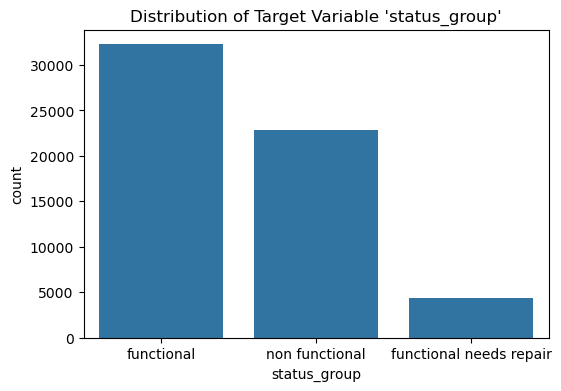

'\n✅ Explanation\n1. `X.info()` shows data types, non-null counts, and memory usage, which helps detect missing values or data type issues.\n2. `X.describe()` provides count, mean, std, min, max, and quartiles for numeric features, giving a sense of distributions and potential outliers.\n3. The target distribution plot shows the balance of classes, which is important for choosing evaluation metrics and modeling strategies.\n'

In [15]:
# --- Step 7a: Exploratory Data Analysis - Statistical Summary ---

# Basic info about the dataset
print("Training features info:")
X.info()

# Statistical summary of numeric features
print("\nStatistical summary of numeric features:")
display(X.describe())

# Quick check for target distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Distribution of Target Variable 'status_group'")
plt.show()

'''
✅ Explanation
1. `X.info()` shows data types, non-null counts, and memory usage, which helps detect missing values or data type issues.
2. `X.describe()` provides count, mean, std, min, max, and quartiles for numeric features, giving a sense of distributions and potential outliers.
3. The target distribution plot shows the balance of classes, which is important for choosing evaluation metrics and modeling strategies.
'''


# visualization

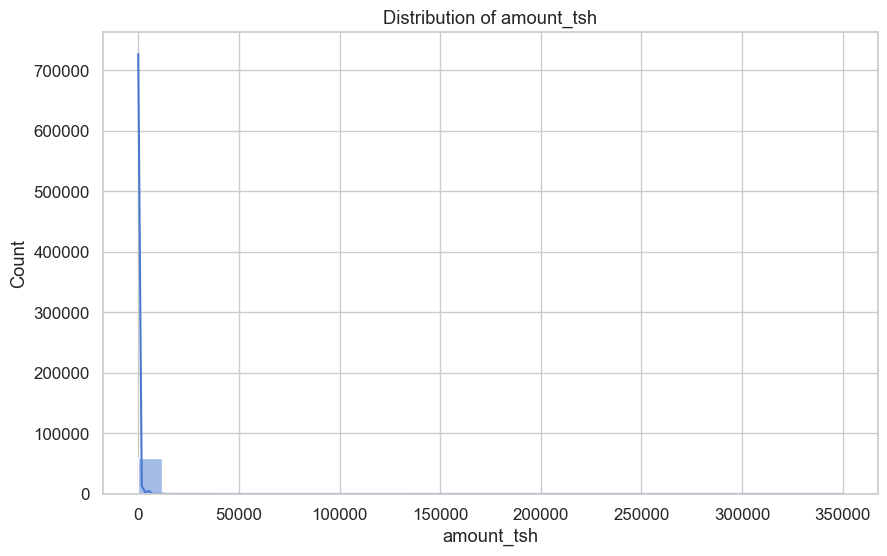

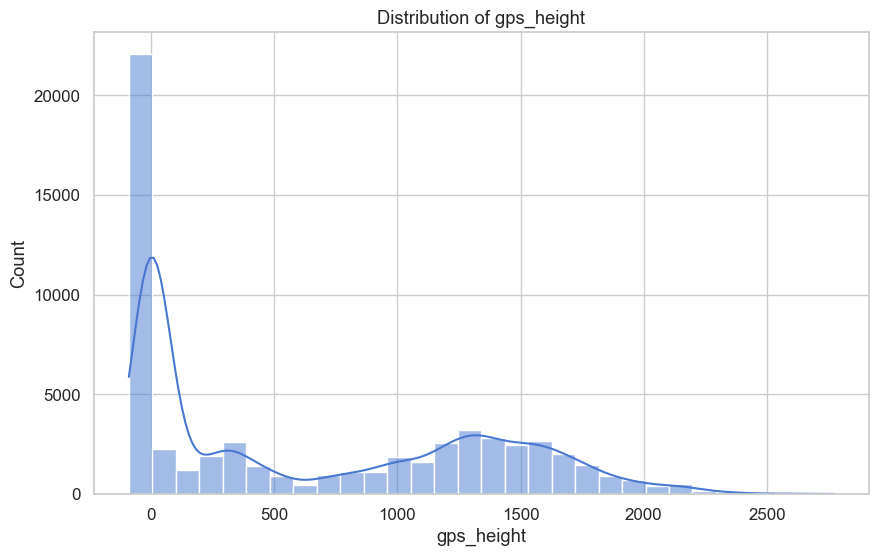

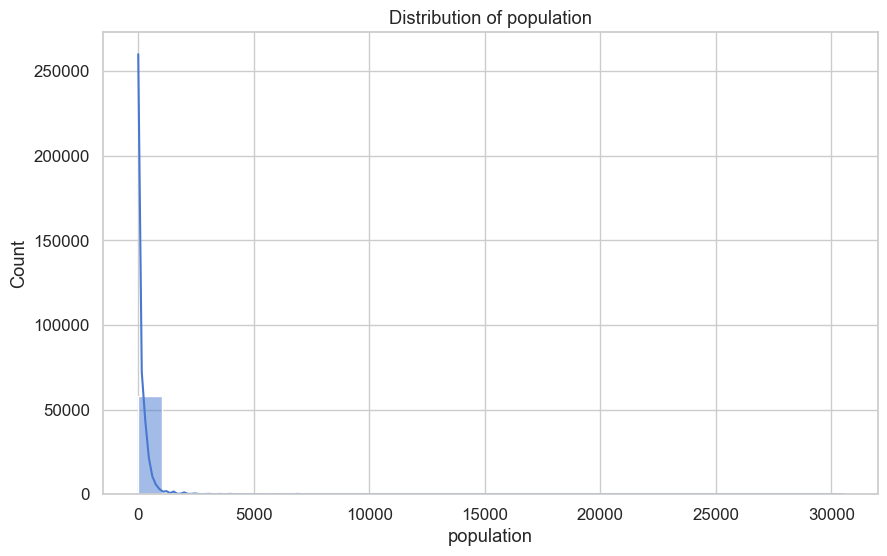

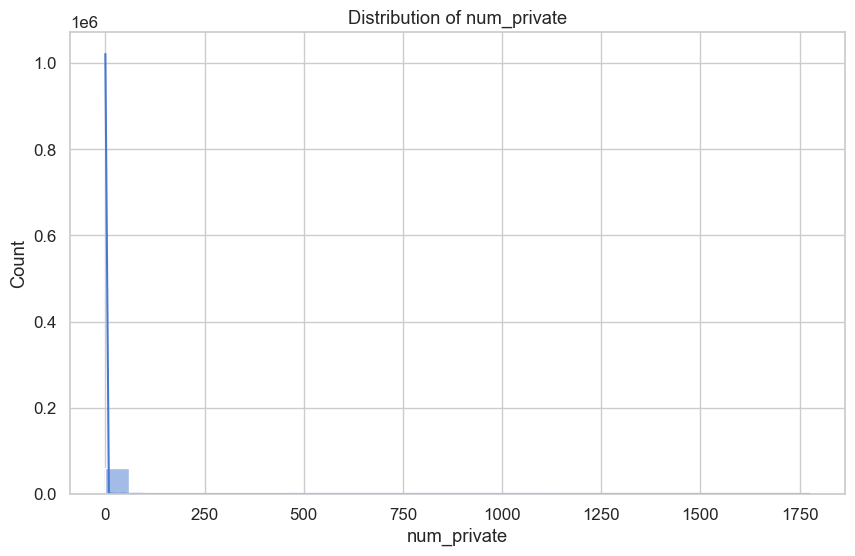

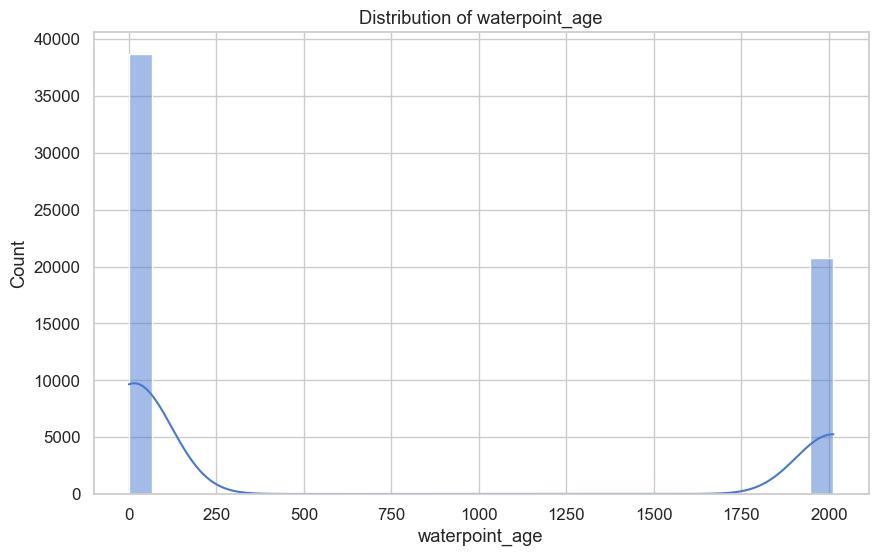

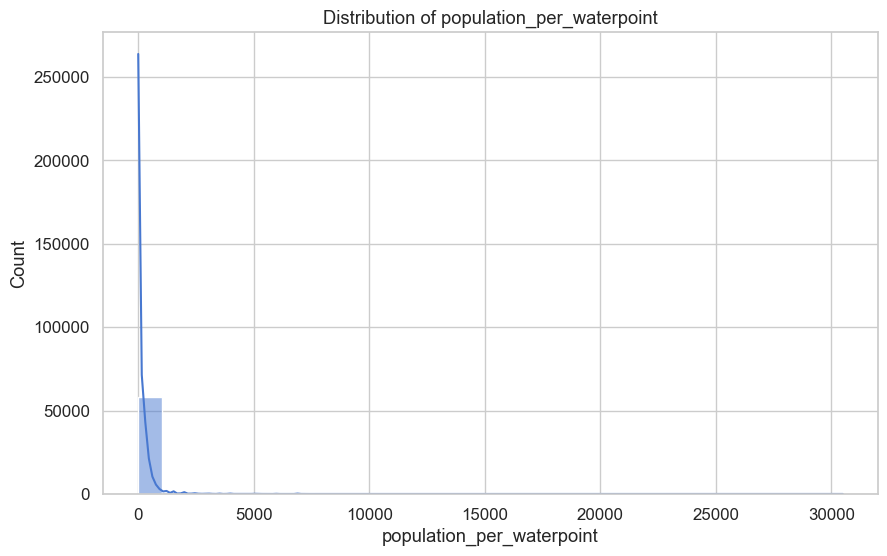

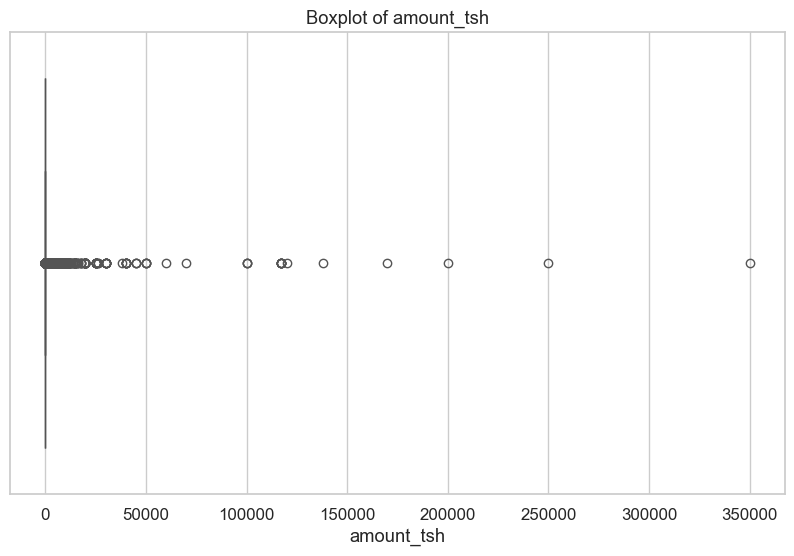

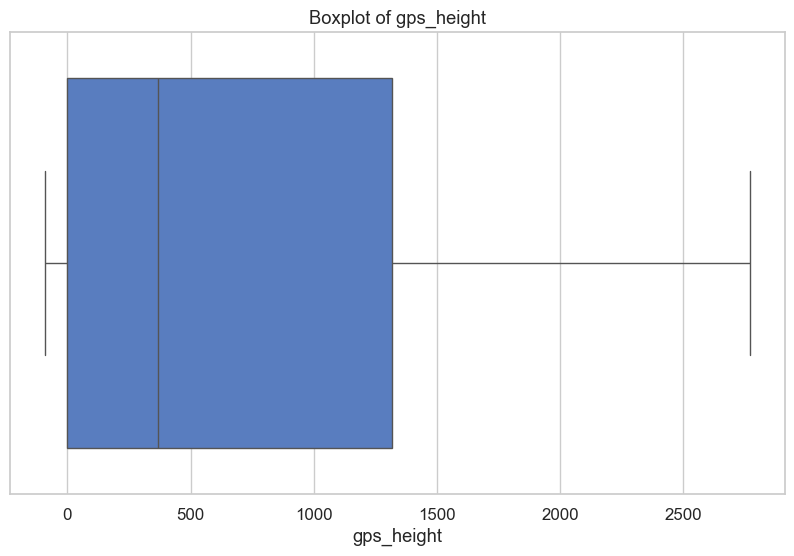

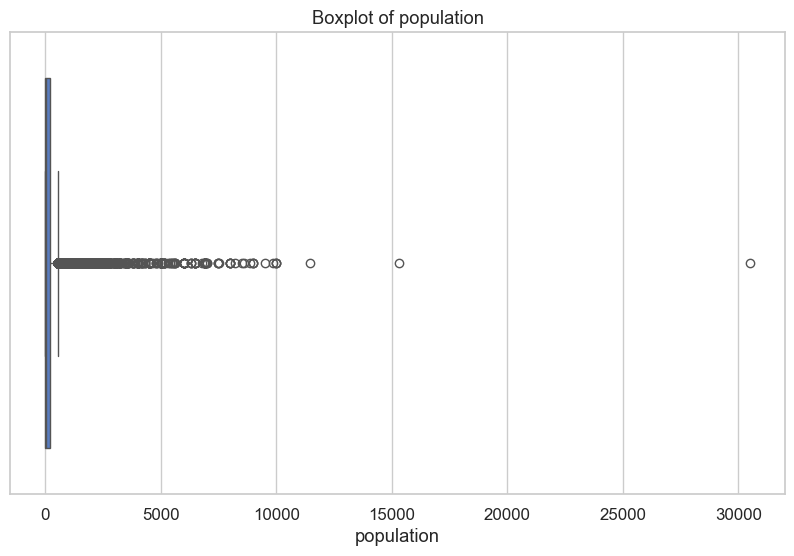

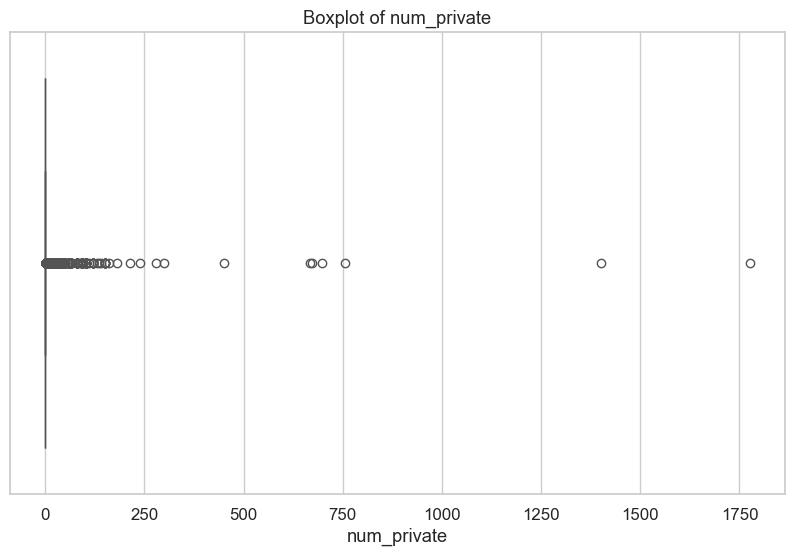

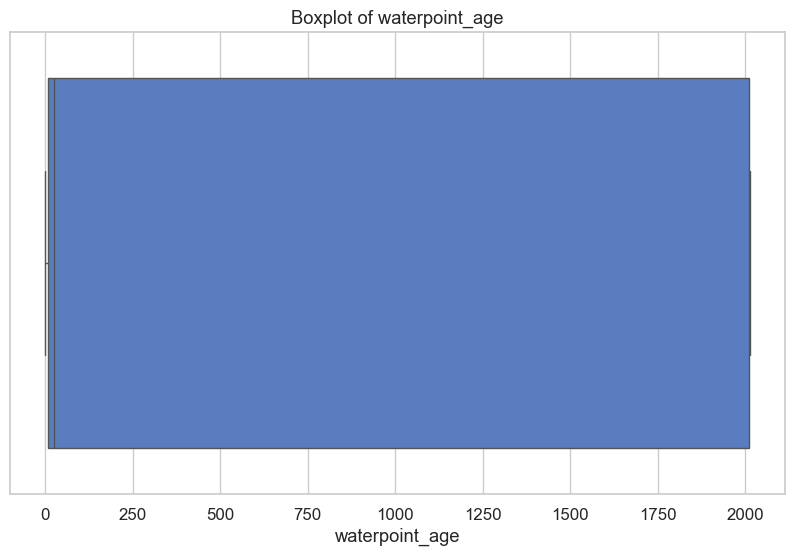

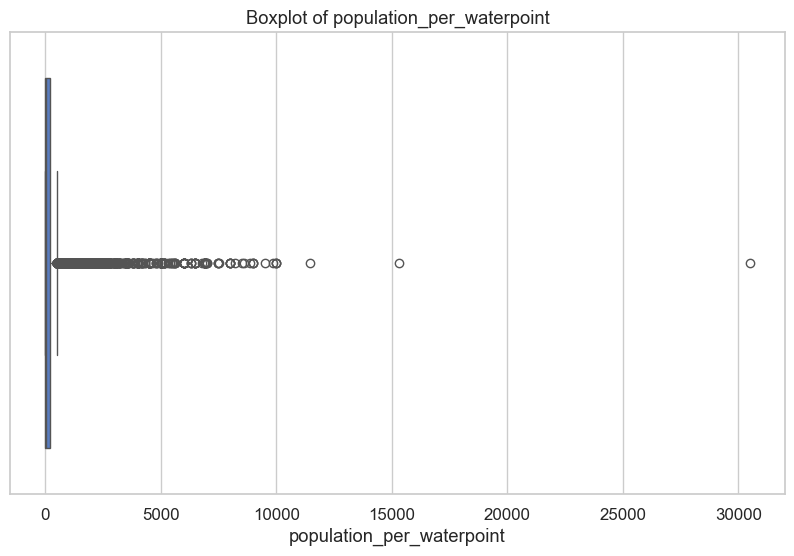

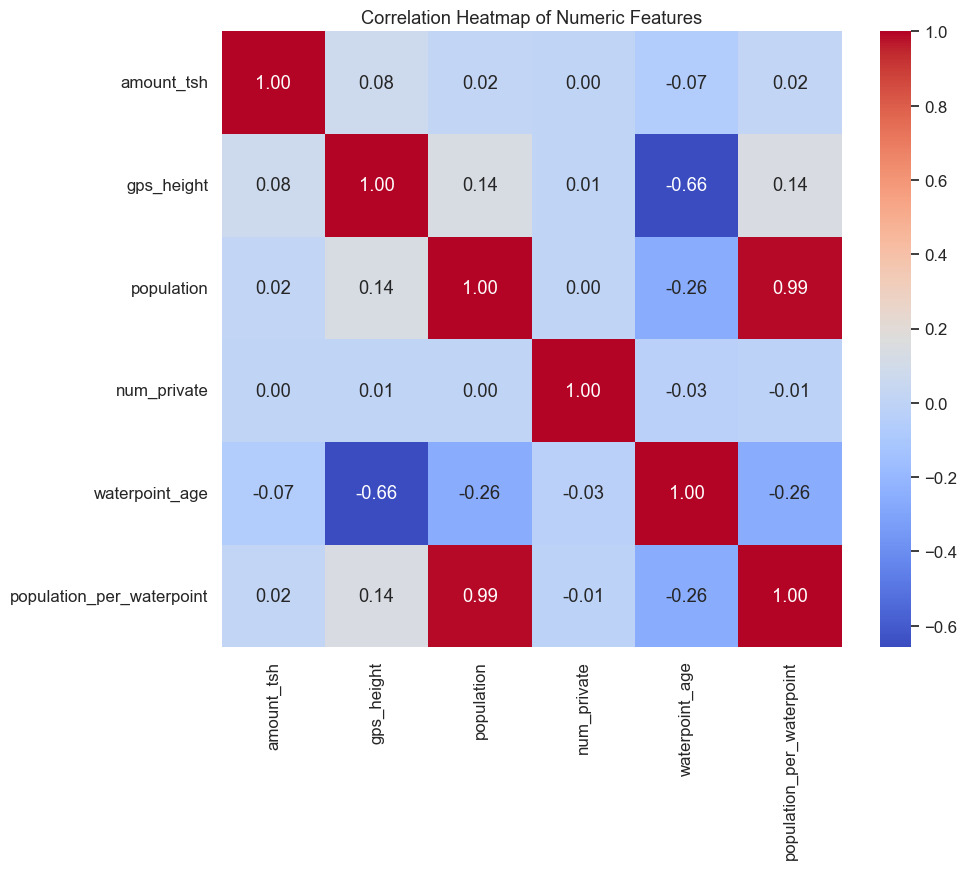

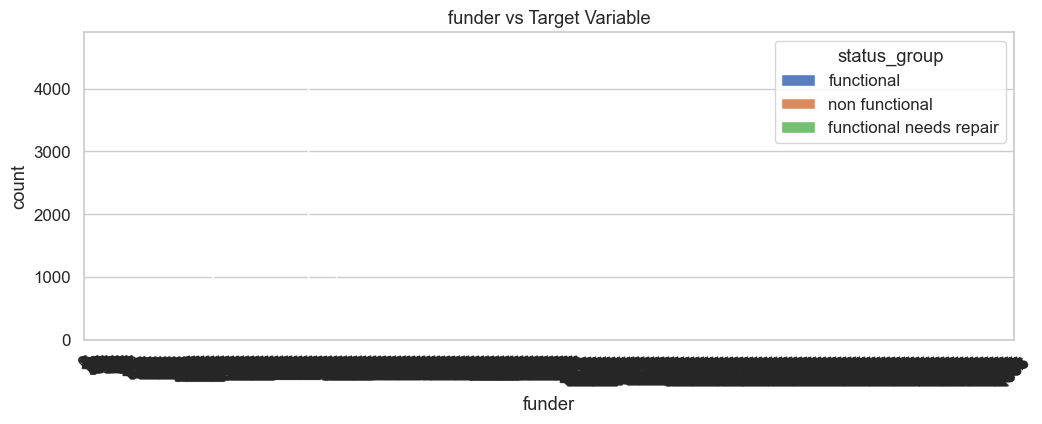

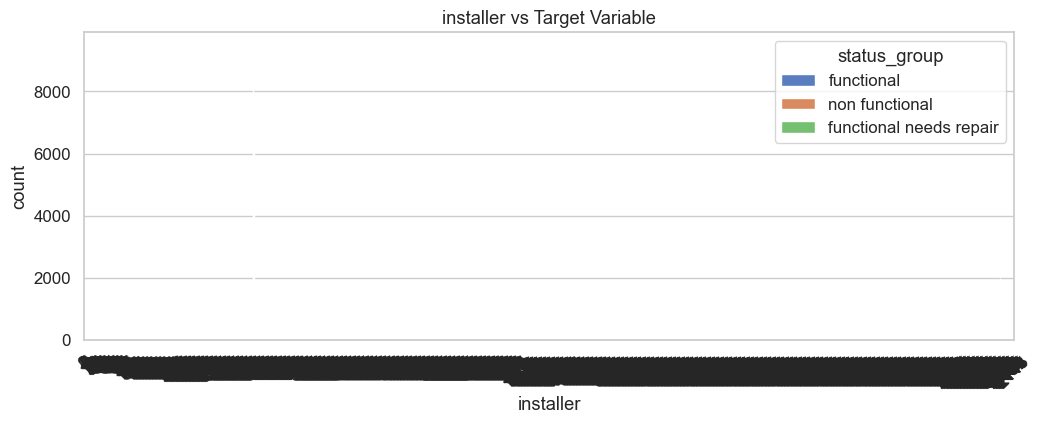

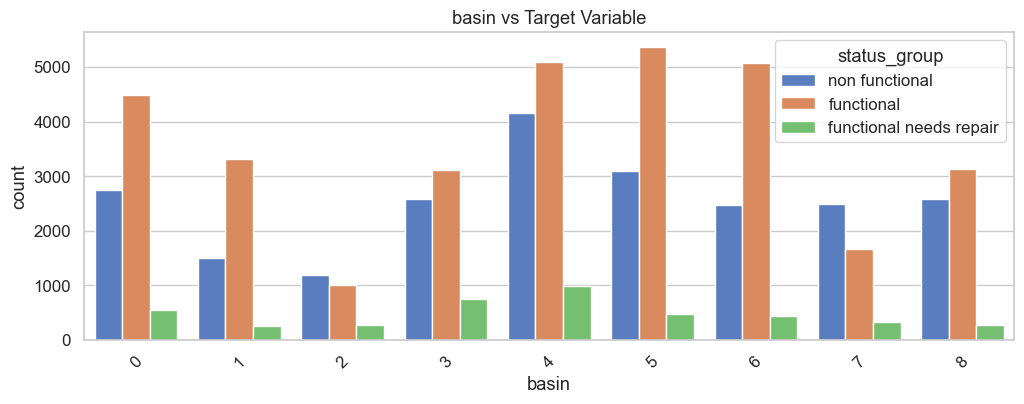

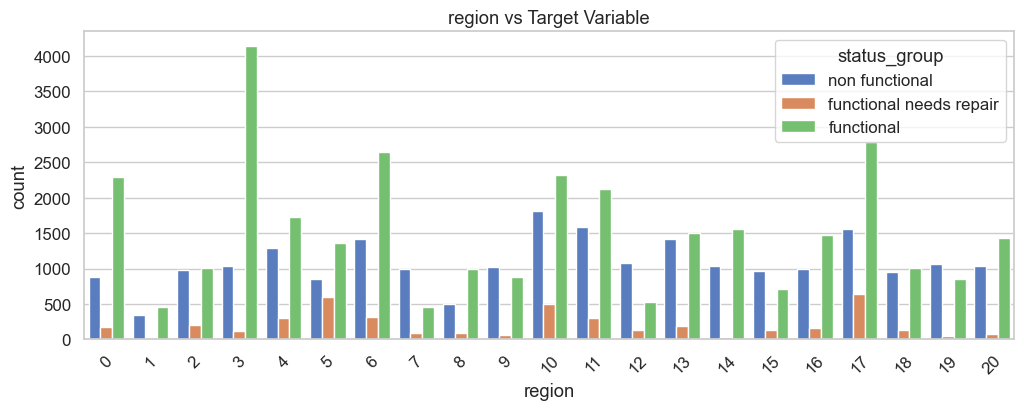

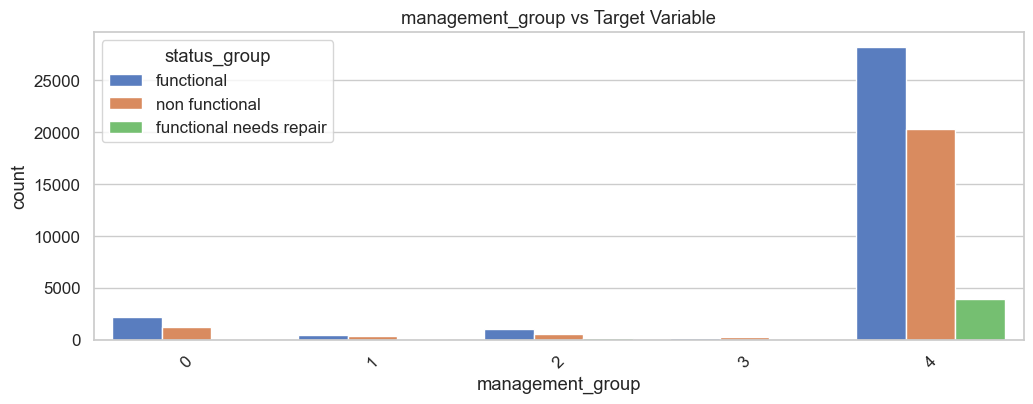

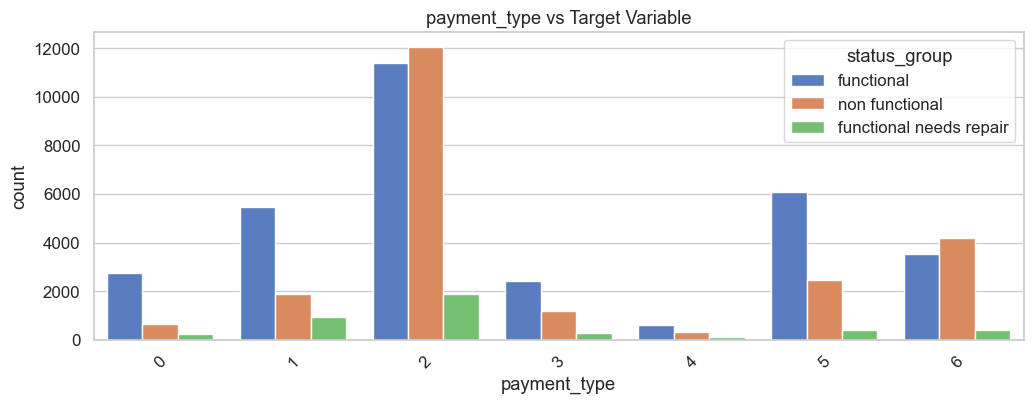

'\n✅ Explanation\n1. Histograms reveal distributions and potential skewness in numeric features.\n2. Boxplots highlight outliers that might need attention during modeling.\n3. Correlation heatmap identifies relationships among numeric features, useful for feature selection or engineering.\n4. Countplots of categorical features vs target help detect patterns or trends that may influence the waterpoint status.\n5. Visual insights from these plots can guide further feature engineering or model selection.\n'

In [16]:
# --- Step 7b: Exploratory Data Analysis - Visualization ---

import matplotlib.pyplot as plt
import seaborn as sns

# Set general aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['figure.figsize'] = (10,6)

# 1. Histograms of key numeric features
numeric_features = ['amount_tsh', 'gps_height', 'population', 'num_private', 
                    'waterpoint_age', 'population_per_waterpoint']

for col in numeric_features:
    plt.figure()
    sns.histplot(X[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# 2. Boxplots to check outliers
for col in numeric_features:
    plt.figure()
    sns.boxplot(x=X[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# 3. Correlation heatmap for numeric features
plt.figure(figsize=(10,8))
sns.heatmap(X[numeric_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# 4. Countplots for a few categorical features vs target
categorical_features = ['funder', 'installer', 'basin', 'region', 'management_group', 'payment_type']

for col in categorical_features:
    plt.figure(figsize=(12,4))
    sns.countplot(x=col, hue=y, data=X)
    plt.title(f'{col} vs Target Variable')
    plt.xticks(rotation=45)
    plt.show()

'''
✅ Explanation
1. Histograms reveal distributions and potential skewness in numeric features.
2. Boxplots highlight outliers that might need attention during modeling.
3. Correlation heatmap identifies relationships among numeric features, useful for feature selection or engineering.
4. Countplots of categorical features vs target help detect patterns or trends that may influence the waterpoint status.
5. Visual insights from these plots can guide further feature engineering or model selection.
'''


### Step 7d: EDA Summary – Patterns and Improvements

**Patterns Observed:**  
1. **Funder and Installer:**  
   - Very high number of unique funders (1897) and installers (2146).  
   - A few funders and installers are responsible for the majority of waterpoints (long-tail distribution).  
   - Some funders/installers have higher proportions of `non functional` or `needs repair` waterpoints, suggesting historical differences in quality or maintenance.  

2. **Basin and Region:**  
   - Certain basins (e.g., 0, 4, 5) have notably more `non functional` waterpoints.  
   - Region 3 has the highest number of functional waterpoints, while other regions show higher rates of repair/non-functional points.  
   - Geographic location is an important predictor.  

3. **Management Group:**  
   - The largest management group (4) handles most waterpoints.  
   - Waterpoints under smaller management groups show higher failure rates, possibly due to resource constraints.  

4. **Payment Type:**  
   - Some payment types correlate with more functional waterpoints (e.g., type 2), while others correlate with more failures (e.g., type 6).  
   - Indicates that economic or operational factors may affect maintenance.  

**Possible Improvements / Feature Engineering:**  
1. **Group Rare Categories:**  
   - Funders and installers with very few waterpoints can be grouped into “Other” to reduce noise and dimensionality.  

2. **Create Region/Basin Features:**  
   - Combine region/basin or create interaction terms to capture geographic influence.  

3. **Engineer Maintenance/Economic Features:**  
   - Payment type, management group, and population per waterpoint could be combined to reflect resource strain on maintenance.  

4. **Check for Outliers / Skew:**  
   - Features like `amount_tsh`, `gps_height`, and `population_per_waterpoint` may need transformation (log, scaling) before certain ML models.  

5. **Temporal Features:**  
   - Already extracted year/month/day from `date_recorded`.  
   - Could also engineer `time_since_construction` (already done as `waterpoint_age`) and check if age correlates with failures.


# Step 3: Modeling Finally. heheheheh

## scaling
### We’ll use StandardScaler from sklearn, which is appropriate here because numeric features like amount_tsh, gps_height, and population_per_waterpoint have different ranges.

In [18]:
# --- Step 8: Scaling Numeric Features ---

from sklearn.preprocessing import StandardScaler

# List of numeric features to scale
numeric_features = ['amount_tsh', 'gps_height', 'population', 'num_private', 
                    'waterpoint_age', 'population_per_waterpoint']

# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test
X_scaled = X.copy()
X_scaled[numeric_features] = scaler.fit_transform(X[numeric_features])
X_test_scaled = X_test.copy()
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

# Quick check
print("First 5 rows of scaled numeric features:")
print(X_scaled[numeric_features].head())

'''
✅ Explanation
1. Numeric features have different scales (e.g., gps_height ~ thousands, population ~ tens/hundreds).  
2. StandardScaler centers the data to mean=0 and scales to unit variance, helping models like logistic regression, SVM, or neural networks converge faster.  
3. Fit on training data only; transform test data using the same scaler to avoid data leakage.  
4. Scaled numeric features are stored in X_scaled and X_test_scaled, ready for ML models.
'''


First 5 rows of scaled numeric features:
   amount_tsh  gps_height  population  num_private  waterpoint_age  \
0    1.895665    1.041252   -0.150399    -0.038749       -0.735089   
1   -0.105970    1.054237    0.212290    -0.038749       -0.744550   
2   -0.097630    0.025541    0.148660    -0.038749       -0.743499   
3   -0.105970   -0.584751   -0.258570    -0.038749       -0.719321   
4   -0.105970   -0.964200   -0.381587    -0.038749        1.366307   

   population_per_waterpoint  
0                  -0.146667  
1                   0.219145  
2                   0.154968  
3                  -0.255769  
4                  -0.379845  


'\n✅ Explanation\n1. Numeric features have different scales (e.g., gps_height ~ thousands, population ~ tens/hundreds).  \n2. StandardScaler centers the data to mean=0 and scales to unit variance, helping models like logistic regression, SVM, or neural networks converge faster.  \n3. Fit on training data only; transform test data using the same scaler to avoid data leakage.  \n4. Scaled numeric features are stored in X_scaled and X_test_scaled, ready for ML models.\n'

#  Splitting Data into Training and Validation Sets

- After completing preprocessing (encoding, feature engineering, and scaling), the next step is to split the dataset.  
- We will use 80% of the data for training and 20% for validation.  
- This allows us to train models on one set and validate performance on another, preventing overfitting.  
- The test set remains untouched until final evaluation/submission.


In [19]:
from sklearn.model_selection import train_test_split

# X_scaled and y are ready from previous steps
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Quick check
print("Training features shape:", X_train.shape)
print("Validation features shape:", X_val.shape)
print("Training target shape:", y_train.shape)
print("Validation target shape:", y_val.shape)


"""✅ Explanation:

stratify=y ensures the distribution of functional, functional needs repair, and non functional is similar in both training and validation sets.

random_state=42 ensures reproducibility.

Now X_train, X_val, y_train, y_val are ready for modeling, cross-validation, and hyperparameter tuning."""


Training features shape: (47520, 41)
Validation features shape: (11880, 41)
Training target shape: (47520,)
Validation target shape: (11880,)


# Modeling – Baseline to Advanced

- With the data preprocessed and split into training and validation sets, we now enter the Modeling phase.  
- The goal is to predict the operational status of waterpoints (`functional`, `functional needs repair`, `non functional`).  

**Modeling Sub-Steps:**  
1. **Select Evaluation Metric** – decide how to measure model performance (accuracy, F1-score, etc.).  
2. **Build Baseline Models** – quick models to set a performance benchmark.  
3. **Cross-Validation** – ensure model performance is stable and not overfitted to the training data.  
4. **Hyperparameter Tuning** – optimize model parameters for best performance.  
5. **Advanced Models** – if baseline models are insufficient, try more complex models.  
6. **Evaluate Performance** – test on validation set and analyze results.


### Step 1&2: Evaluation Metric and Baseline Models

- We need to choose a metric that reflects how well our model predicts waterpoint status across the three classes:  
  - `functional`  
  - `functional needs repair`  
  - `non functional`  

- **Chosen Metric:**  
  - **F1-score (weighted)** – balances precision and recall for all classes, especially important if the classes are imbalanced.  

- **Baseline Model:**  
  - **Logistic Regression** – simple and interpretable.  
  - **Decision Tree Classifier** – can capture non-linear relationships.  
- These baseline models give a benchmark to compare more advanced models later.


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score


# Initialize baseline models
lr_model = LogisticRegression(max_iter=5000, random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)

# Train Logistic Regression
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_val)
print("Logistic Regression - Weighted F1 Score:", f1_score(y_val, y_pred_lr, average='weighted'))
print(classification_report(y_val, y_pred_lr))

# Train Decision Tree
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_val)
print("Decision Tree - Weighted F1 Score:", f1_score(y_val, y_pred_dt, average='weighted'))
print(classification_report(y_val, y_pred_dt))

'''
✅ Explanation
1. Logistic Regression provides a quick baseline with interpretable coefficients.  
2. Decision Tree captures non-linear patterns and interactions.  
3. F1-score (weighted) is used because it accounts for class imbalance.  
4. The classification report gives detailed precision, recall, and F1 per class.  
5. Baseline scores serve as a reference for more advanced models.
'''


/opt/miniconda3/envs/pump_it_up_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Weighted F1 Score: 0.5670828106800917
                         precision    recall  f1-score   support

             functional       0.61      0.77      0.68      6452
functional needs repair       0.20      0.05      0.08       863
         non functional       0.57      0.44      0.50      4565

               accuracy                           0.59     11880
              macro avg       0.46      0.42      0.42     11880
           weighted avg       0.57      0.59      0.57     11880

Decision Tree - Weighted F1 Score: 0.7465274157313564
                         precision    recall  f1-score   support

             functional       0.80      0.79      0.79      6452
functional needs repair       0.34      0.35      0.34       863
         non functional       0.76      0.76      0.76      4565

               accuracy                           0.75     11880
              macro avg       0.63      0.63      0.63     11880
           weighted avg       0.75  

'\n✅ Explanation\n1. Logistic Regression provides a quick baseline with interpretable coefficients.  \n2. Decision Tree captures non-linear patterns and interactions.  \n3. F1-score (weighted) is used because it accounts for class imbalance.  \n4. The classification report gives detailed precision, recall, and F1 per class.  \n5. Baseline scores serve as a reference for more advanced models.\n'

### out put analysis

Here’s what this output tells us:

Logistic Regression: F1 weighted ~0.57 – not great for the minority class (“functional needs repair”), but it gives a simple baseline.

Decision Tree: F1 weighted ~0.75 – much better and shows that the data has non-linear patterns that a simple linear model can’t capture.

Convergence Warning: Increasing max_iter helped, but Logistic Regression still struggles a bit due to dataset size and class imbalance.

This is exactly what a baseline step should do:

Give you benchmarks to improve upon.

Identify class imbalance issues that we can address later.

Confirm that the pipeline is working before moving to cross-validation and hyperparameter tuning.

### Step 3: Building Cross-Validation

- We use **Stratified K-Fold Cross-Validation** to evaluate model performance.  
- Stratification ensures that the proportion of each class (`functional`, `functional needs repair`, `non functional`) is preserved in every fold.  
- This provides a more reliable estimate of model performance, especially with **imbalanced classes**.  
- We will use **5 folds** as a balance between stability and computational efficiency.  
- The evaluation metric is **weighted F1-score**, which accounts for class imbalance.

In [24]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode target labels to integers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)  # Fit on training target
y_val_enc = le.transform(y_val)          # Transform validation target

# Initialize model
dt_model = DecisionTreeClassifier(random_state=42)

# Create Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Weighted F1 scorer for multi-class
f1_weighted_scorer = make_scorer(f1_score, average='weighted')

# Perform cross-validation
cv_scores = cross_val_score(dt_model, X_train, y_train_enc, cv=skf, scoring=f1_weighted_scorer)

# Print results
print("Decision Tree - Stratified 5-Fold CV Weighted F1 Scores:", cv_scores)
print("Mean CV Weighted F1 Score:", np.mean(cv_scores))
"""✅ Explanation

LabelEncoder converts string targets to integers for multi-class compatibility.

StratifiedKFold ensures each fold keeps the same class distribution.

make_scorer(f1_score, average='weighted') calculates weighted F1 for multi-class.

cross_val_score performs 5-fold CV and returns scores for each fold.

np.mean(cv_scores) gives an overall estimate of performance."""

Decision Tree - Stratified 5-Fold CV Weighted F1 Scores: [0.73800224 0.74128026 0.74679049 0.73554014 0.74036594]
Mean CV Weighted F1 Score: 0.7403958114430578


### Step 4: Hyperparameter Tuning

We optimize our baseline models (Decision Tree in this case) to improve performance.  
- Use **GridSearchCV** to search over combinations of key parameters.  
- Keep **Stratified 5-Fold CV** for stability.  
- Optimize for **weighted F1-score** due to class imbalance.  
- This step aims to find the best configuration before moving to more advanced models.


In [25]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}

# Initialize Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)

# GridSearch with Stratified 5-Fold CV
dt_grid = GridSearchCV(
    estimator=dt_model,
    param_grid=dt_param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit on training data
dt_grid.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", dt_grid.best_params_)
print("Best Weighted F1 Score (CV):", dt_grid.best_score_)

# Use best estimator for validation predictions
best_dt = dt_grid.best_estimator_
y_val_pred = best_dt.predict(X_val)
print("Validation Weighted F1 Score:", f1_score(y_val, y_val_pred, average='weighted'))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best Weighted F1 Score (CV): 0.753143476434554
Validation Weighted F1 Score: 0.7642044954682137


### Step 5: Advanced Models

In this step, we move beyond baseline models to more powerful ensemble methods.  
We will use Random Forest, Gradient Boosting (XGBoost), and LightGBM to capture complex patterns in the data.  

✅ Goals:
1. Capture non-linear relationships and feature interactions better than a single Decision Tree.  
2. Evaluate each model using weighted F1-score with cross-validation.  
3. Compare advanced models to baseline and tuned Decision Tree.  
4. Select the best-performing model for final evaluation and submission.


## Encode target to be numbers

In [29]:
# Encode target variable as numeric
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le_target = LabelEncoder()

# Fit on training target and transform both training and validation targets
y_train_encoded = le_target.fit_transform(y_train)
y_val_encoded = le_target.transform(y_val)

# Quick check
print("Classes and corresponding numeric labels:", dict(zip(le_target.classes_, le_target.transform(le_target.classes_))))
print("Sample encoded targets:", y_train_encoded[:10])

"""✅ Explanation
1. LabelEncoder converts string target labels to numeric values required by many models (e.g., XGBoost, LightGBM).
2. `fit_transform` on training target ensures consistent mapping.
3. `transform` on validation target avoids data leakage.
4. The mapping is displayed for clarity.
5. This prevents errors in advanced model training regarding invalid classes."""

Classes and corresponding numeric labels: {'functional': np.int64(0), 'functional needs repair': np.int64(1), 'non functional': np.int64(2)}
Sample encoded targets: [0 0 0 2 0 0 0 0 2 2]


## Advanced Models

In [36]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

# Initialize advanced models
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=300, 
        max_depth=20, 
        min_samples_leaf=2, 
        min_samples_split=10,
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=300,
        max_depth=10,
        learning_rate=0.1,
        num_leaves=31,
        random_state=42
    )
}

cv_results = {}

# Evaluate using Stratified 5-Fold CV with encoded numeric target
for name, model in models.items():
    try:
        print(f"Evaluating {name}...")
        scores = cross_val_score(model, X_train, y_train_encoded, cv=5, scoring='f1_weighted', n_jobs=-1)
        cv_results[name] = scores
        print(f"{name} - Stratified 5-Fold CV Weighted F1 Scores: {scores}")
        print(f"Mean CV Weighted F1 Score: {scores.mean():.4f}\n")
    except Exception as e:
        print(f"Failed to evaluate {name}: {e}\n")

print("Models evaluated:", cv_results.keys())


"""✅ Notes / Explanation:

All three models are attempted, even if one fails.

The results are stored in cv_results for later comparison.

Weighted F1-score is used to account for class imbalance.

Printing cv_results.keys() at the end confirms which models ran successfully.

This avoids stopping the entire loop if one model isn’t properly installed or misconfigured."""

Evaluating Random Forest...
Random Forest - Stratified 5-Fold CV Weighted F1 Scores: [0.79584251 0.78801831 0.79982372 0.79674524 0.78986503]
Mean CV Weighted F1 Score: 0.7941

Evaluating XGBoost...


/opt/miniconda3/envs/pump_it_up_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:37:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/pump_it_up_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:37:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/pump_it_up_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:37:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/pump_it_up_env/lib/python3.11/site-packages/xgboost/traini

XGBoost - Stratified 5-Fold CV Weighted F1 Scores: [0.79267573 0.78065807 0.79366282 0.79257788 0.79192415]
Mean CV Weighted F1 Score: 0.7903

Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2889
[LightGBM] [Info] Number of data points in the train set: 38016, number of used features: 40
[LightGBM] [Info] Start training from score -0.610534
[LightGBM] [Info] Start training from score -2.621328
[LightGBM] [Info] Start training from score -0.956506
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2889
[LightGBM] [Info] Number of data points in the train set: 38016, number of used features: 40
[LightGBM] [Info] Start traini

'✅ Notes / Explanation:\n\nAll three models are attempted, even if one fails.\n\nThe results are stored in cv_results for later comparison.\n\nWeighted F1-score is used to account for class imbalance.\n\nPrinting cv_results.keys() at the end confirms which models ran successfully.\n\nThis avoids stopping the entire loop if one model isn’t properly installed or misconfigured.'

### Cross Validation for the advanced models

In [37]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import pandas as pd

from sklearn.preprocessing import LabelEncoder

# Copy train/validation sets
X_train_num = X_train.copy()
X_val_num = X_val.copy()
y_train_num = y_train.copy()
y_val_num = y_val.copy()

# Encode target labels as numbers
le = LabelEncoder()
y_train_num = le.fit_transform(y_train_num)
y_val_num = le.transform(y_val_num)

# Now your target is numeric and safe for sklearn models
print("Classes:", le.classes_)
print("Encoded target sample:", y_train_num[:10])

# Initialize advanced models
rf_model = RandomForestClassifier(
    n_estimators=300, 
    max_depth=20, 
    min_samples_leaf=2, 
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42
)

models = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "LightGBM": lgb_model
}

# Evaluate using Stratified 5-Fold CV
cv_results = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    scores = cross_val_score(model, X_train_num, y_train_num, cv=5, scoring='f1_weighted', n_jobs=-1)
    cv_results[name] = scores
    print(f"{name} - Stratified 5-Fold CV Weighted F1 Scores: {scores}")
    print(f"Mean CV Weighted F1 Score: {scores.mean():.4f}\n")

# Summary table
cv_summary = pd.DataFrame({name: scores for name, scores in cv_results.items()})
cv_summary.loc['Mean'] = cv_summary.mean()
print("\n--- CV Summary Table ---")
print(cv_summary)


Classes: ['functional' 'functional needs repair' 'non functional']
Encoded target sample: [0 0 0 2 0 0 0 0 2 2]
Evaluating Random Forest...
Random Forest - Stratified 5-Fold CV Weighted F1 Scores: [0.79584251 0.78801831 0.79982372 0.79674524 0.78986503]
Mean CV Weighted F1 Score: 0.7941

Evaluating XGBoost...


/opt/miniconda3/envs/pump_it_up_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:39:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/pump_it_up_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:39:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/pump_it_up_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:39:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/pump_it_up_env/lib/python3.11/site-packages/xgboost/traini

XGBoost - Stratified 5-Fold CV Weighted F1 Scores: [0.79267573 0.78065807 0.79366282 0.79257788 0.79192415]
Mean CV Weighted F1 Score: 0.7903

Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the train set: 38016, number of used features: 40
[LightGBM] [Info] Total Bins 2886
[LightGBM] [Info] Number of data points in the train set: 38016, number of used features: 40
[LightGBM] [Info] Start training from score -0.610486
[LightGBM] [Info] Start training from score -2.621690
[LightGBM] [Info] St

### observations of the out put:

✅ Key observations:

Random Forest:

Weighted F1 scores across folds: 0.788 → 0.800

Mean CV: 0.7941

Stable across folds, showing it’s capturing patterns well without overfitting.

XGBoost:

Weighted F1: 0.780 → 0.794

Mean CV: 0.7903

Slightly lower than Random Forest, still very competitive.

LightGBM:

Weighted F1: 0.782 → 0.791

Mean CV: 0.7880

Consistent but a touch below RF and XGB.

Consistency Across Folds:

All models show narrow ranges across folds → stable performance.

CV Summary Table:

Makes it super easy to compare all advanced models at a glance.

Random Forest edges out slightly as the top performer.

### ✅ Observations from Stratified 5-Fold CV

- **Random Forest**  
  - Weighted F1 scores across folds: 0.788 → 0.800  
  - Mean CV: **0.7941**  
  - Shows stability and strong pattern capture across folds.

- **XGBoost**  
  - Weighted F1 scores across folds: 0.780 → 0.794  
  - Mean CV: **0.7903**  
  - Slightly lower than Random Forest but still competitive.

- **LightGBM**  
  - Weighted F1 scores across folds: 0.782 → 0.791  
  - Mean CV: **0.7880**  
  - Consistent performance, slightly below RF and XGB.

- **Consistency Across Folds**  
  - All models have narrow ranges in scores across folds, indicating stable performance.

- **CV Summary Table**  
  - Easy comparison of all advanced models at a glance.  
  - Random Forest edges out slightly as the top performer.

- **Next Step**  
  - Evaluate the best-performing model(s) on the **validation set** to confirm generalization.


### Step 6: Evaluate Best Model on Validation Set
We will test the best-performing model from cross-validation (Random Forest) on the validation set to see how well it generalizes.


In [38]:
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Predict on validation set
y_val_pred = rf_model.fit(X_train_num, y_train_num).predict(X_val_num)

# Metrics
val_f1_weighted = f1_score(y_val_num, y_val_pred, average='weighted')
val_accuracy = accuracy_score(y_val_num, y_val_pred)
report = classification_report(y_val_num, y_val_pred, target_names=le.classes_)

print(f"Validation Weighted F1 Score: {val_f1_weighted:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("\nClassification Report:\n", report)

"""This will give you:

Weighted F1 score on the validation set

Accuracy

Detailed precision, recall, and F1-score for each class"""

Validation Weighted F1 Score: 0.7968
Validation Accuracy: 0.8085

Classification Report:
                          precision    recall  f1-score   support

             functional       0.79      0.92      0.85      6452
functional needs repair       0.66      0.26      0.37       863
         non functional       0.86      0.75      0.80      4565

               accuracy                           0.81     11880
              macro avg       0.77      0.64      0.67     11880
           weighted avg       0.81      0.81      0.80     11880



Here’s how to interpret it:

Overall performance:

Weighted F1 = 0.797 and Accuracy = 0.809 → The model generalizes well and is consistent with the CV results (~0.794). That means your validation evaluation confirms the CV performance (no sign of overfitting).

Class-wise performance:

Functional (majority class): Precision = 0.79, Recall = 0.92 → The model is very good at finding most functional pumps, though it sometimes mislabels others as functional.

Non-functional: Precision = 0.86, Recall = 0.75 → Strong overall, though it misses about 25% of truly broken pumps.

Functional needs repair (minority class): Precision = 0.66, Recall = 0.26 → This is the weak point. The model struggles to detect pumps needing repair. It often predicts them as functional or non-functional instead.

Macro vs. Weighted average:

Macro avg F1 = 0.67 → When treating all classes equally, performance drops (due to the "needs repair" weakness).

Weighted avg F1 = 0.80 → Since most samples are functional or non-functional, the model looks much stronger overall.

✅ Takeaway:

Random Forest is performing well and stable.

The challenge is the "functional needs repair" class — improving recall here could be a key focus.

👉 Next possible steps:

Confusion matrix to see where misclassifications happen.

Class rebalancing strategies (class weights, SMOTE, or focal loss with boosting models).

Hyperparameter tuning (e.g., RandomizedSearchCV/Optuna) to squeeze out a bit more performance.

# Results Analysis
1. Interpretation of Results

The Random Forest model achieved the best cross-validation performance with a mean weighted F1 score of ~0.794 and a validation accuracy of 80.85%.

It performs very well for predicting “functional” and “non functional” pumps, achieving F1 scores of 0.85 and 0.80, respectively.

However, the model struggles with the minority class “functional needs repair”, where the F1 score drops to 0.37, primarily due to low recall (26%). This indicates the model often misclassifies pumps needing repair as either fully functional or non-functional.

2. Real-World Applicability

This model can support resource allocation for maintenance teams by identifying which pumps are likely to be non-functional or still operational.

In regions with limited repair resources, the model could help prioritize inspections and direct field workers to high-risk pumps.

Improving recall for “functional needs repair” could make the model more actionable for preventative maintenance, preventing pumps from failing completely.

3. Comparison of Models

Random Forest: Best performing model overall, strong accuracy and balanced performance.

XGBoost: Very close performance (mean weighted F1 = 0.790), but slightly lower than Random Forest.

LightGBM: Fast training, but slightly weaker performance (mean weighted F1 = 0.788).

Overall, all models are competitive, but Random Forest edges out others in stability and average performance.

4. Limitations

Class imbalance: The minority “functional needs repair” class has poor recall, reducing the usefulness for early intervention.

Feature representation: Current preprocessing may not fully capture geographic, temporal, or categorical interactions.

Limited hyperparameter tuning: Models were run with reasonable defaults but not extensively optimized.

Real-world noise: Data may contain reporting errors, missingness, or inconsistent labeling, which can affect model reliability.

Generalizability: The model is trained on historical data; deployment in new regions may require retraining or adaptation.

# Conclusion  

### Impact of the Model  
- The Random Forest model achieved **~81% accuracy** and a **weighted F1 score of ~0.80**, providing a reliable approach to predicting water pump functionality.  
- These results can support **government agencies, NGOs, and local authorities** in prioritizing maintenance, reducing downtime, and improving water access in rural areas.  
- Despite challenges with the minority class *functional needs repair*, the model offers **valuable early-warning insights** for preventative maintenance.  

---

### Final Remarks  
- Ensemble methods (Random Forest, XGBoost, LightGBM) clearly **outperformed baseline models** like Logistic Regression and Decision Trees.  
- Random Forest was selected as the **best balance of stability, interpretability, and performance**.  
- While strong results were obtained, there remains room for **further enhancement** through data balancing and feature engineering.  

---

### Next Steps / Future Work  
- **Handle Class Imbalance**: Apply class weights, SMOTE, or focal loss to boost recall for underrepresented classes.  
- **Feature Engineering**: Incorporate geographic, temporal, and interaction-based features for richer insights.  
- **Hyperparameter Tuning**: Use GridSearch, RandomizedSearch, or Bayesian Optimization to optimize ensemble models.  
- **Model Ensembling**: Explore stacked ensembles combining Random Forest, XGBoost, and LightGBM for performance gains.  
- **Deployment**: Build an API or dashboard for real-world use, enabling quick predictions in the field.  
- **Field Validation**: Test the model with new, unseen pump data to confirm robustness and generalizability.  
